In [167]:
import os
import seaborn as sns
import pandas as pd
from google.colab import drive
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from __future__ import division
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

from osgeo import ogr
from osgeo import osr

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install -q xlrd

In [35]:
path_ = "/content/drive/MyDrive/Knowledge/Data_Science_Prj/lc_2017.tif"

In [168]:
ds = gdal.Open(path_)
ds_band = ds.GetRasterBand(1)
nodataval = ds_band.GetNoDataValue()
ds_arr = ds.ReadAsArray().astype(np.int64)
print(ds_arr)
print(ds_arr.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3029, 2540)


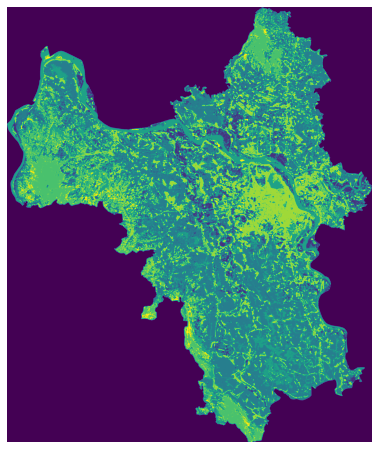

In [169]:
#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")

In [170]:
uniq = np.unique(ds_arr)
uniq = np.delete(uniq, 0)
print(uniq)

[1 2 3 4 5 6 7]


In [106]:
df=pd.read_excel('/content/drive/My Drive/Knowledge/Data_Science_Prj/EPA_merged_2019.xlsx')

In [171]:
point_set = df.drop_duplicates(subset=['Lat', 'Lon'])
point_set = point_set.loc[:,['Lat', 'Lon']]
lat_lon = point_set.to_numpy()
print(lat_lon)

[[ 21.0263 105.8515]
 [ 21.0399 105.8473]
 [ 21.0074 105.8358]
 [ 21.05   105.74  ]
 [ 21.0269 105.7731]
 [ 21.05   105.782 ]
 [ 21.0197 105.8147]
 [ 21.0152 105.7999]
 [ 20.9883 105.8549]
 [ 21.0058 105.7485]]


In [172]:
prj = ds.GetProjection()
gt = ds.GetGeoTransform()
print(prj)
print(gt)

PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]
(529605.0, 30.0, 0.0, 2365125.0, 0.0, -30.0)


In [109]:
!pip install pyproj

In [173]:
from pyproj import Proj
prj = Proj('+proj=utm +zone=48 +ellps=WGS84 +datum=WGS84 +units=m +no_defs', preserve_units=False, errcheck=True)

In [174]:
lat_lon_after = []
for p in lat_lon:   lat_lon_after.append(prj(p[1], p[0]))

print(lat_lon_after)

[(588482.3081783054, 2325294.2526949174), (588037.857835659, 2326797.2090993715), (586861.724449972, 2323193.747170578), (576883.2770319555, 2327859.6292411787), (580334.7832654524, 2325319.215299665), (581247.1194804814, 2327880.448834465), (584661.822486213, 2324543.802991303), (583126.2578250611, 2324037.9645576538), (588858.1323010594, 2321090.2226356324), (577789.3663453121, 2322971.6867247666)]


In [175]:
def get_coords_at_point(gt, pos):
    row = int((pos[0] - gt[0])/(gt[1]))
    col = int((pos[1] - gt[3])/(gt[5]))
    return col, row

In [176]:
point_coor = []
for p in lat_lon_after:
    col, row = get_coords_at_point(gt, p)
    point_coor.append([row, col])

print(point_coor)

[[1962, 1327], [1947, 1277], [1908, 1397], [1575, 1242], [1690, 1326], [1721, 1241], [1835, 1352], [1784, 1369], [1975, 1467], [1606, 1405]]


In [177]:
R = 1000 * 20
# radius = 20 kilometer
R_cell = R/(gt[1])
print( R_cell)
# circle = (row, col, R_cell)

666.6666666666666


In [178]:
def int_ceiling(x):
        return int(np.ceil(x))

def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        for j in range(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
    return buffer_points

    # Below is The 20 kilometer radius cutting area from all Buffer-Points Center

**The Area cover by Center Buffer-Points**
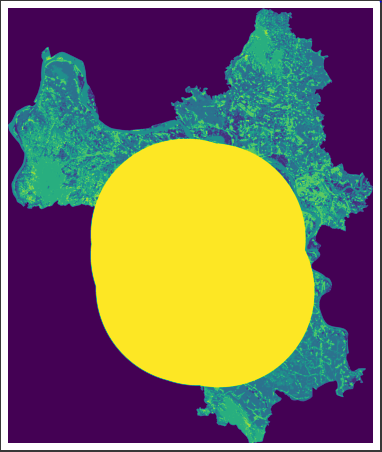

In [ ]:
buffers_points = []
for pc in point_coor:
    circle = (pc[0], pc[1], R_cell)
    buffers_points.append(points_in_circle(circle, ds_arr))

# print(buffers_points)
"""
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plt.axis("off")
img = plt.imshow(ds_arr, cmap = "viridis")
"""

In [181]:
statistic = []
for bp in buffers_points:
    counts = np.zeros(len(uniq))
    for x in uniq:
        for i in bp:
            if i == x:
                counts[x - 1] += 1
    statistic.append(counts)

for st in statistic: print(st)

[128255.  10931. 429708. 122066.  74952. 216929.  44128.]
[123921.  11971. 405893. 110980.  76237. 205554.  45048.]
[143537.  11919. 445363. 133468.  77003. 269831.  47856.]
[185607.  19081. 374385. 104957.  88449. 324475.  66802.]
[173713.  17620. 407162. 104743.  81739. 329579.  60191.]
[159759.  16653. 382769.  92989.  84956. 277206.  61259.]
[150646.  14723. 421814. 119319.  78891. 285914.  52367.]
[161859.  15509. 420579. 119730.  79748. 315053.  55166.]
[139163.  10416. 477283. 153585.  68508. 264367.  43054.]
[195768.  19732. 408702. 129410.  75406. 391245.  60311.]
